2025-08-25 16:32:03.110147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756139523.304155      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756139523.357949      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train1 - ['sad.jpg', 'saadgirl.jpg', 'happy.jpg', 'data', 'very-happy-people.jpg']
Train2 - ['sad.jpg', 'saadgirl.jpg', 'happy.jpg', 'data', 'very-happy-people.jpg']
['sad.jpg', 'saadgirl.jpg', 'happy.jpg', 'data', 'very-happy-people.jpg']
Train Classes - ['sad', 'happy']
Validation Classes - ['sad', 'happy']


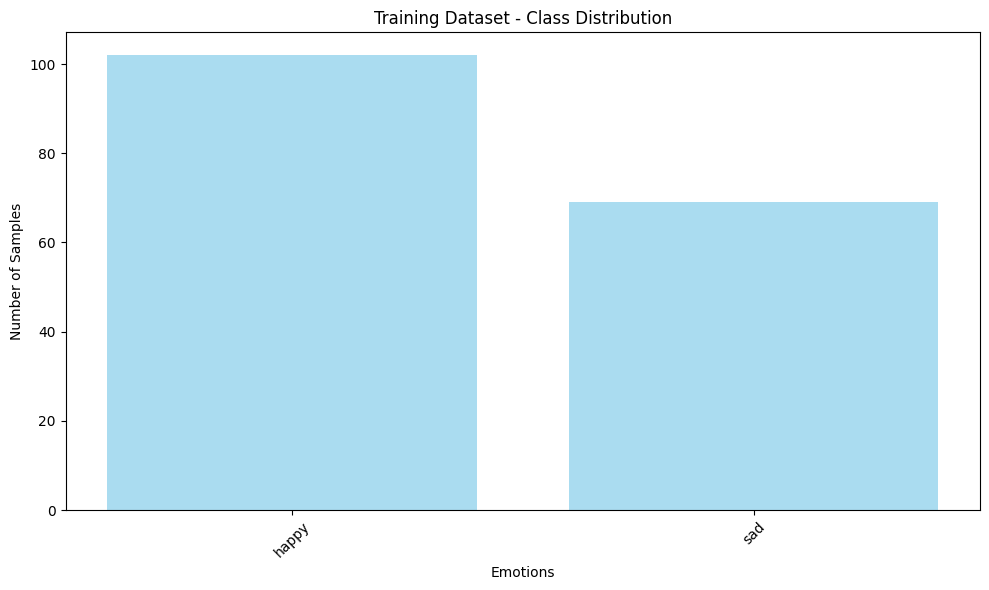

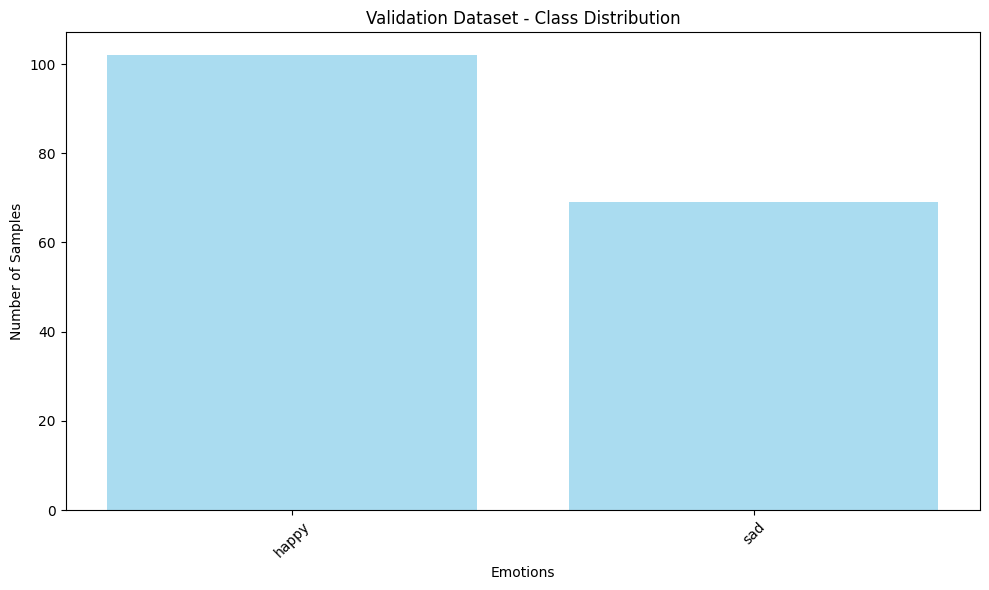

Train images shape: (171, 48, 48, 1)
Test images shape: (171, 48, 48, 1)
Train labels shape: (171, 2)
Test labels shape: (171, 2)


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools
     

# Constants
IMG_SIZE = 48
DATA_DIR = '/kaggle/input/happy-and-sad-image'
     

import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
train1 = os.listdir(DATA_DIR)
train2 = os.listdir(DATA_DIR)
print(f'Train1 - {train1}')
print(f'Train2 - {train2}')
data_dir = DATA_DIR
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + f"/{train1[3]}")
classes_valid = os.listdir(data_dir + f"/{train2[3]}")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')
     
import torchvision.transforms as transforms

# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
     

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Load the datasets
train_dataset = ImageFolder(root=os.path.join(DATA_DIR, train1[3]), transform=transform)
val_dataset = ImageFolder(root=os.path.join(DATA_DIR, train2[3]), transform=transform)
     
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Load the datasets
train_dataset = ImageFolder(root=os.path.join(DATA_DIR, train1[3]), transform=transform)
val_dataset = ImageFolder(root=os.path.join(DATA_DIR, train2[3]), transform=transform)
     

def plot_class_distribution(dataset, title):
    class_counts = {}
    for _, label in dataset:
        class_name = emotion_labels[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Emotions')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return class_counts

# Define emotion_labels based on the dataset classes
emotion_labels = {i: class_name for i, class_name in enumerate(train_dataset.classes)}

train_counts = plot_class_distribution(train_dataset, 'Training Dataset')
val_counts = plot_class_distribution(val_dataset, 'Validation Dataset')

# ------------------------- Convert Dataset to NumPy Arrays -------------------------

def dataset_to_numpy(dataset, n_samples):
    images = []
    labels = []
    # Use the actual number of samples available in the dataset
    num_samples_to_extract = min(n_samples, len(dataset))
    for i in range(num_samples_to_extract):
        img_tensor, label = dataset[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)  # (1, 48, 48) → (48, 48, 1)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Define number of samples to extract (these values will be capped by the actual dataset size)
n_train = 5000
n_test = 3000

train_images, train_labels = dataset_to_numpy(train_dataset, n_train)
test_images, test_labels = dataset_to_numpy(val_dataset, n_test)

# Clip values (just in case)
train_images = np.clip(train_images, 0.0, 1.0)
test_images = np.clip(test_images, 0.0, 1.0)

# One-hot encode labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(emotion_labels))
test_labels_categorical = to_categorical(test_labels, num_classes=len(emotion_labels))

# ------------------------- Final Shape Checks -------------------------

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    verbose=1,
    factor=0.5,
    min_lr=1e-4
)

# Load pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model

# Build custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(emotion_labels), activation='softmax')  # match dataset classes
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1756139563.309517      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,109,186 (57.64 MB)

 Trainable params: 394,498 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [3]:
# Resize and convert grayscale -> RGB
from tensorflow.image import resize
import numpy as np

def prepare_for_vgg(images):
    # Resize to (224,224) and repeat grayscale channel -> RGB
    resized = np.array([resize(img, (224,224)).numpy() for img in images])
    if resized.shape[-1] == 1:  # if grayscale
        resized = np.repeat(resized, 3, axis=-1)
    return resized

train_images_vgg = prepare_for_vgg(train_images)
test_images_vgg = prepare_for_vgg(test_images)

print("Train shape:", train_images_vgg.shape)
print("Test shape:", test_images_vgg.shape)

Train shape: (171, 224, 224, 3)
Test shape: (171, 224, 224, 3)


In [4]:
history = model.fit(
    train_images_vgg, train_labels_categorical,
    validation_data=(test_images_vgg, test_labels_categorical),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/30


I0000 00:00:1756139568.234989      94 service.cc:148] XLA service 0x7944f800f690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756139568.235766      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756139568.646773      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4922 - loss: 0.8155

I0000 00:00:1756139577.138620      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5012 - loss: 0.8188 - val_accuracy: 0.5965 - val_loss: 0.7896 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.5851 - loss: 0.7119 - val_accuracy: 0.6959 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6835 - loss: 0.6243 - val_accuracy: 0.5965 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6990 - loss: 0.5499 - val_accuracy: 0.7895 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7281 - loss: 0.5584 - val_accuracy: 0.7778 - val_loss: 0.4933 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7896 - loss: 0.5116 - val_accuracy: 0.7836 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.7946 - loss: 0.4853 - val_accuracy: 0.8246 - val_

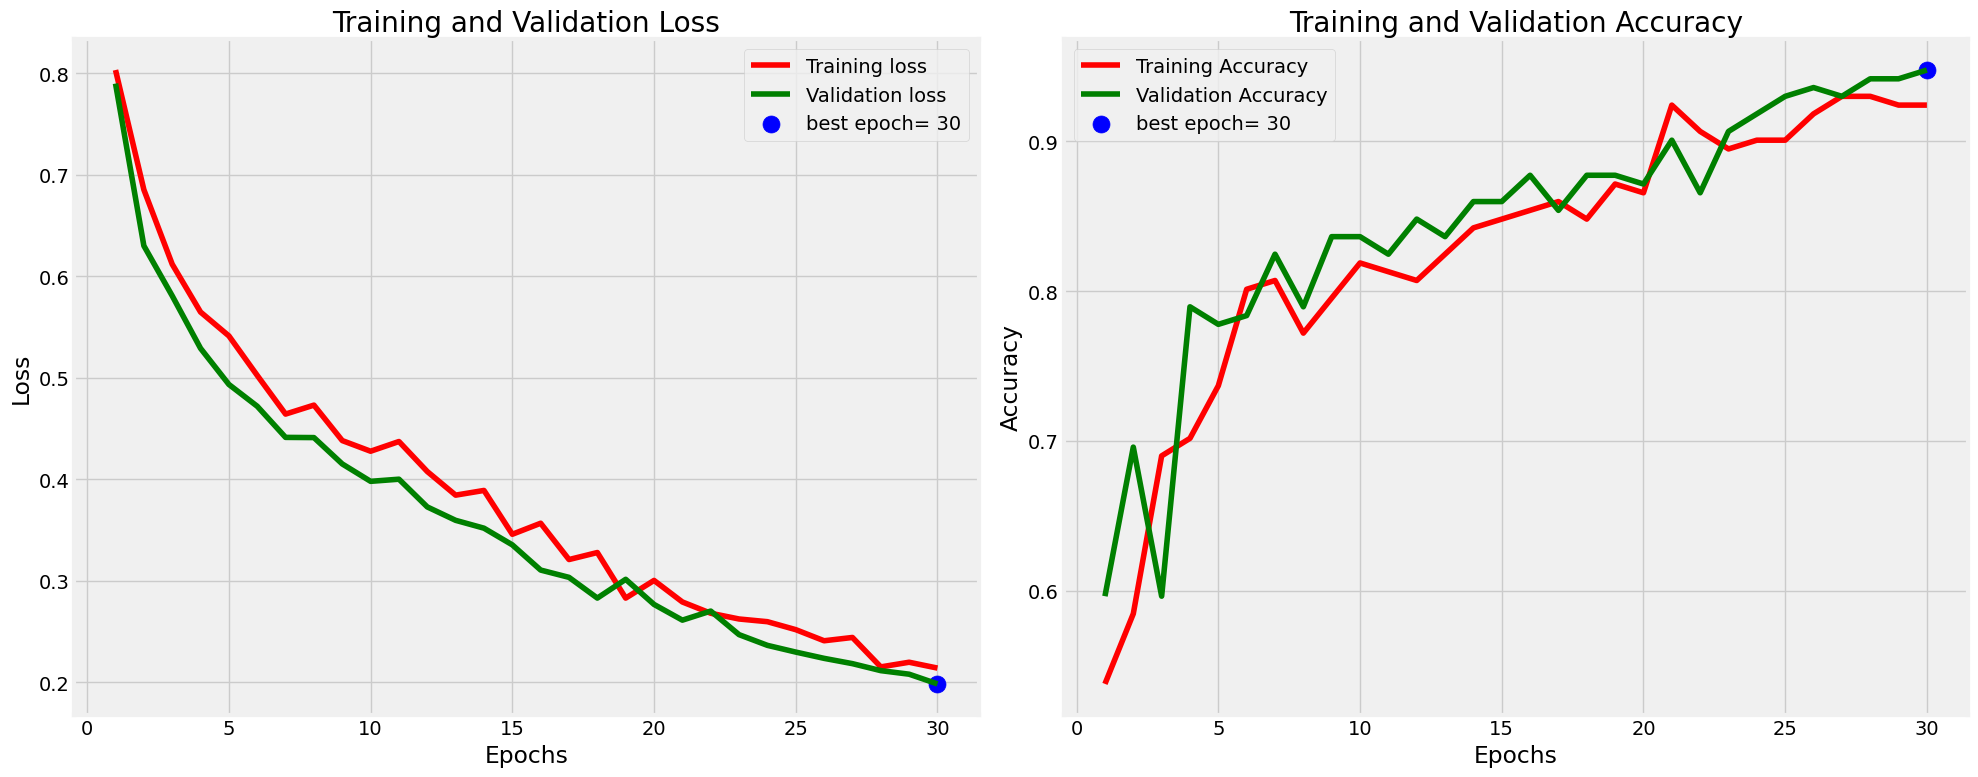

6/6 - 0s - 71ms/step - accuracy: 0.9474 - loss: 0.1984
Test Loss: 0.1984
Test Accuracy: 0.9474
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step

Classification Report:
              precision    recall  f1-score   support

       happy       0.96      0.95      0.96       102
         sad       0.93      0.94      0.94        69

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



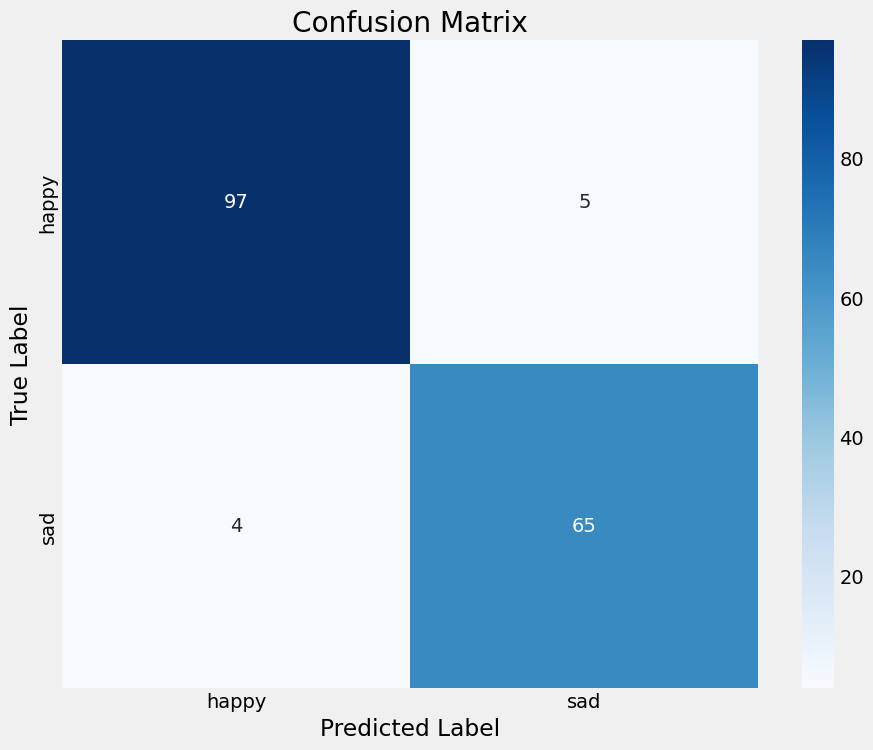

In [5]:
# =============================
# Training History Visualization
# =============================

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# =============================
# Evaluate the model on the test set
# =============================
test_loss, test_accuracy = model.evaluate(test_images_vgg, test_labels_categorical, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# =============================
# Predictions and Classification Report
# =============================
from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot back to integer labels for ground truth
true_labels = np.argmax(test_labels_categorical, axis=1)

# Predictions
predictions = model.predict(test_images_vgg)
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(emotion_labels.values())))

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()